In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from google.colab import drive

#Read the dataset and  Display Real and Fake Images

In [ ]:
# Define the paths to the real and fake images
real = "/content/drive/MyDrive/real_and_fake_face/training_real"
fake = "/content/drive/MyDrive/real_and_fake_face/training_fake"

# List all files in the directories
real_path = os.listdir(real)
fake_path = os.listdir(fake)

def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image[..., ::-1]

# Create DataFrames to store image paths and labels
real_df = pd.DataFrame({'path': [os.path.join(real, img) for img in real_path], 'label': 1})
fake_df = pd.DataFrame({'path': [os.path.join(fake, img) for img in fake_path], 'label': 0})

# Concatenate the dataframes
df = pd.concat([real_df, fake_df], ignore_index=True)

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)



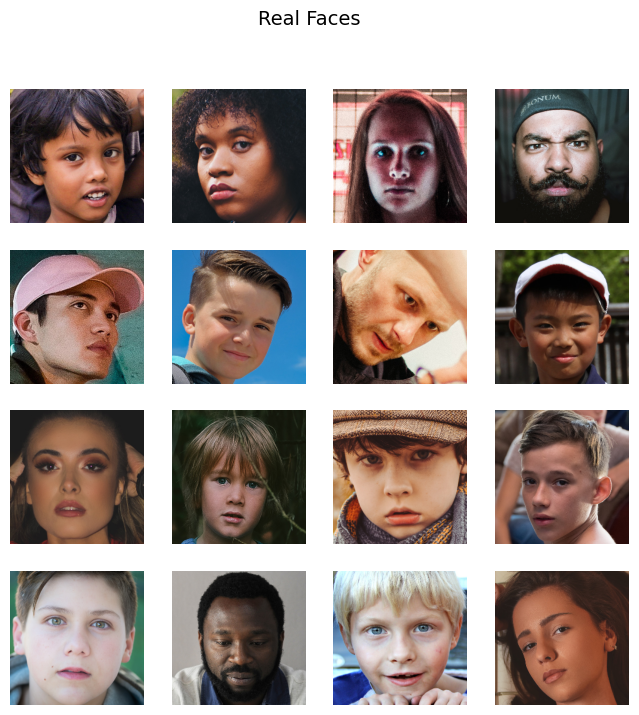

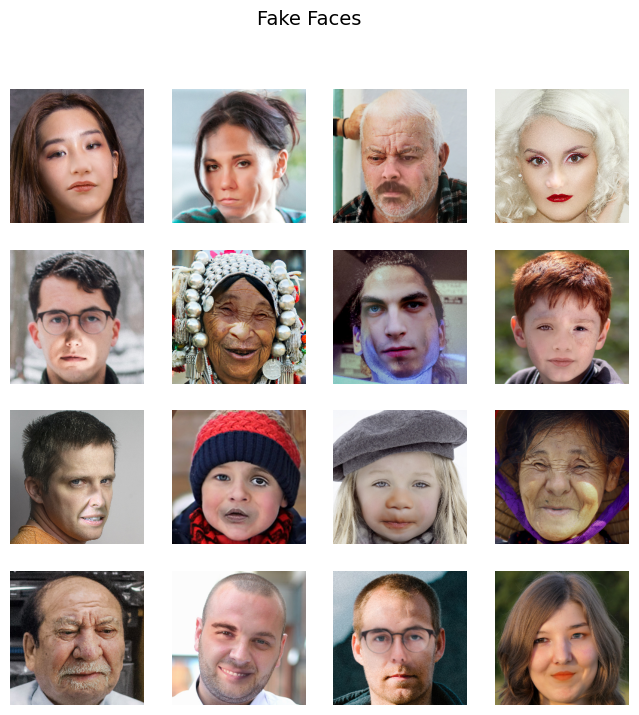

In [ ]:
def load_img(path):
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image: {path}")
        return None
    image = cv2.resize(image, (224, 224))
    return image[..., ::-1]  # Convert BGR to RGB

# Function to display a grid of images
def display_image_grid(image_paths, title, num_images=16):
    fig = plt.figure(figsize=(8, 8))

    for i in range(min(num_images, len(image_paths))):
        img_path = image_paths[i]
        img = load_img(img_path)

        if img is None:
            continue

        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# Display a grid of real face images
real_image_paths = [os.path.join(real, img) for img in real_path[:16]]
display_image_grid(real_image_paths, "Real Faces")

# Display a grid of fake face images
fake_image_paths = [os.path.join(fake, img) for img in fake_path[:16]]
display_image_grid(fake_image_paths, "Fake Faces")

In [ ]:
# Convert labels to strings
df['label'] = df['label'].astype(str)

# Display a few images with Canny edge detection
def display_images_with_edges(df, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img_path = df['path'].iloc[i]
        img = load_img(img_path)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Apply Canny edge detection
        edges = cv2.Canny(gray, 100, 200)

        # Plot original and edge-detected images
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detected Image')
        plt.axis('off')

    plt.show()

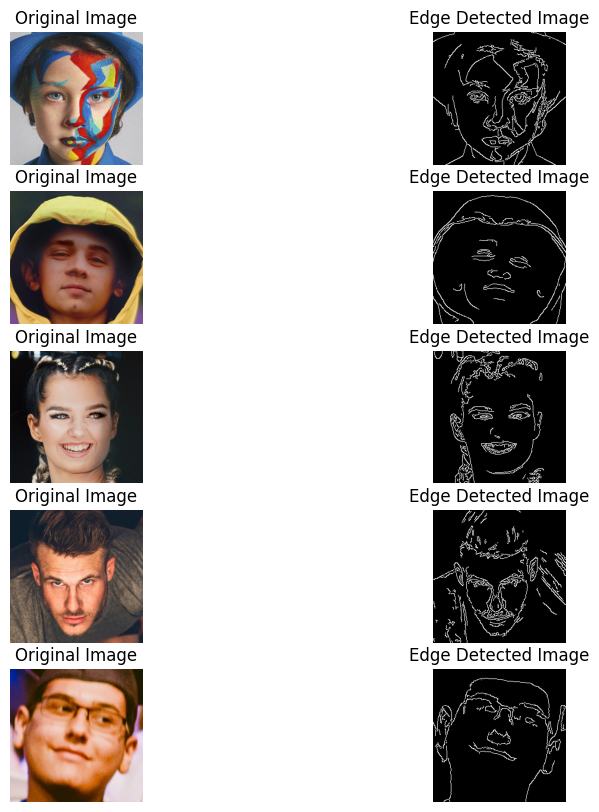

In [ ]:
# Call the function to display images with edges
display_images_with_edges(df)

#Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Data Generators with Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Model building with Transfer Learning and Fine-tuning
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = True  # Unfreeze the base model
# Optional: Unfreeze some top layers for fine-tuning
for layer in base_model.layers[:-10]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer='l2'),  # Increased units
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


Found 1632 validated image filenames belonging to 2 classes.
Found 409 validated image filenames belonging to 2 classes.


In [ ]:
# Check output shapes of the data generators
x_batch, y_batch = next(train_generator)
print(f"Batch shape: {x_batch.shape}, Labels shape: {y_batch.shape}")

Batch shape: (32, 224, 224, 3), Labels shape: (32,)


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Training the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 72s 981ms/step - accuracy: 0.5140 - loss: 7.8669 - val_accuracy: 0.5892 - val_loss: 7.2656 - learning_rate: 1.0000e-04
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 745ms/step - accuracy: 0.5887 - loss: 7.0964 - val_accuracy: 0.6235 - val_loss: 6.5840 - learning_rate: 1.0000e-04
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 719ms/step - accuracy: 0.6102 - loss: 6.4526 - val_accuracy: 0.5868 - val_loss: 6.0560 - learning_rate: 1.0000e-04
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 762ms/step - accuracy: 0.6397 - loss: 5.8581 - val_accuracy: 0.6284 - val_loss: 5.4961 - learning_rate: 1.0000e-04
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 742ms/step - accuracy: 0.6695 - loss: 5.3259 - val_accuracy: 0.5599 - val_loss: 5.2082 - learning_rate: 1.0000e-04
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 880ms/step - accuracy: 0.6484 - loss: 4.8774 - val_accuracy: 0.6455 - val_loss: 4.6045 - learning_rate: 1.0000e-04
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 730ms/step - accuracy: 0.64

In [ ]:
# Evaluate the model on training and test data
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the results
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 695ms/step - accuracy: 0.6192 - loss: 3.4001
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - accuracy: 0.5308 - loss: 3.7195
Train Loss: 3.4110
Train Accuracy: 0.6336
Test Loss: 3.6330
Test Accuracy: 0.5770


#Plot visualization

In [ ]:
import plotly.graph_objects as go

# Assuming history contains your training history data
epochs = list(range(1, len(history.history['accuracy']) + 1))
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
fig_accuracy = go.Figure()
fig_accuracy.add_trace(go.Scatter(x=epochs, y=train_accuracy, mode='lines+markers', name='Train Accuracy'))
fig_accuracy.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines+markers', name='Validation Accuracy'))
fig_accuracy.update_layout(title='Training and Validation Accuracy', xaxis_title='Epochs', yaxis_title='Accuracy')

# Show the plot
fig_accuracy.show()


In [ ]:
import plotly.graph_objects as go
# Plot training and validation loss
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)),
                              y=history.history['loss'],
                              mode='lines+markers',
                              name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)),
                              y=history.history['val_loss'],
                              mode='lines+markers',
                              name='Validation Loss'))
fig_loss.update_layout(title='Training and Validation Loss',
                       xaxis_title='Epochs',
                       yaxis_title='Loss')
fig_loss.show()
